In [1]:
!pip install pymupdf
!pip install chromadb



Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install sentence-transformers

Defaulting to user installation because normal site-packages is not writeable


In [3]:
pip install langchain chromadb sentence-transformers pypdf


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import fitz  # PyMuPDF
import os
import re
from sentence_transformers import SentenceTransformer
import chromadb
from langchain.text_splitter import RecursiveCharacterTextSplitter
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
print("✅ All libraries imported successfully!")

C:\Users\jsdha\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All libraries imported successfully!


In [5]:
embedding_model = None
chroma_client = None
collection = None

print("✅ Global variables initialized")

✅ Global variables initialized


In [6]:
def load_embedding_model():
    """Load the sentence transformer model for embeddings"""
    global embedding_model
    print("🧠 Loading embedding model (BAAI/bge-base-en-v1.5)...")
    print("   This may take a moment on first run...")

    # CHANGE: Use a better embedding model
    embedding_model = SentenceTransformer('BAAI/bge-base-en-v1.5')
    # Alternative options:
    # embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    # embedding_model = SentenceTransformer('intfloat/e5-base-v2')

    print("✅ Embedding model loaded successfully!")
    return embedding_model


def initialize_database(db_path="./vector_db_july200"):
    """Initialize ChromaDB and create/get collection"""
    global chroma_client, collection

    print("💾 Initializing ChromaDB...")

    # ✅ FIX: Use a shared persistent collection
    chroma_client = chromadb.PersistentClient(path="chromadb_store")
    collection = chroma_client.get_or_create_collection(
        name="rag-chunks",
        metadata={"hnsw:space": "cosine"}  # Better for semantic similarity
    )
    print("✅ Persistent ChromaDB initialized with collection 'rag-chunks'")

    return collection


# Initialize everything
load_embedding_model()
initialize_database()


🧠 Loading embedding model (BAAI/bge-base-en-v1.5)...
   This may take a moment on first run...
✅ Embedding model loaded successfully!
💾 Initializing ChromaDB...
✅ Persistent ChromaDB initialized with collection 'rag-chunks'


Collection(name=rag-chunks)

In [7]:
def extract_text_generic_smart(pdf_path, skip_first_pages=None):
    """Generic PDF extraction with smart page detection"""
    print(f"📄 Processing: {os.path.basename(pdf_path)}")
    
    doc = None
    try:
        doc = fitz.open(pdf_path)
        total_pages = doc.page_count
        
        # Use smart detection if not specified
        if skip_first_pages is None:
            skip_first_pages = 5  # Default fallback
            
            # Look for Chapter 1 or Introduction
            for page_num in range(5, min(20, total_pages)):
                page = doc[page_num]
                text = page.get_text().lower()
                
                if re.search(r'(chapter\s+1|^1\.\s*introduction|^1\.1\s+|^introduction$)', text, re.MULTILINE):
                    skip_first_pages = page_num
                    print(f"✅ Found content start marker at page {page_num + 1}")
                    break
        
        print(f"📖 Total pages: {total_pages}")
        print(f"⏭️  Skipping first {skip_first_pages} pages")
        
        # Rest of your existing code stays the same...
        start_page = skip_first_pages
        pages_to_process = total_pages - start_page
        
        print(f"📑 Processing pages {start_page + 1} to {total_pages} ({pages_to_process} pages)")
        
        raw_text = ""
        page_texts = []
        structured_content = []
        
        # Extract text from each page with better structure preservation
        for page_num in range(start_page, total_pages):
            try:
                page = doc[page_num]
                
                # Get text with formatting info
                blocks = page.get_text("dict")
                page_structured_text = []
                current_paragraph = []
                
                for block in blocks["blocks"]:
                    if "lines" in block:
                        for line in block["lines"]:
                            if line["spans"]:
                                text = " ".join([span["text"] for span in line["spans"]])
                                font_size = line["spans"][0]["size"] if line["spans"] else 12
                                
                                # If we hit a heading or empty line, save current paragraph
                                if (font_size > 14 or not text.strip()) and current_paragraph:
                                    combined_text = " ".join(current_paragraph)
                                    if combined_text.strip():
                                        page_structured_text.append({
                                            "text": combined_text.strip(),
                                            "is_heading": False,
                                            "font_size": 12,
                                            "page": page_num + 1
                                        })
                                    current_paragraph = []
                                
                                # Add heading or continue paragraph
                                if font_size > 14:
                                    page_structured_text.append({
                                        "text": text.strip(),
                                        "is_heading": True,
                                        "font_size": font_size,
                                        "page": page_num + 1
                                    })
                                elif text.strip():
                                    current_paragraph.append(text.strip())
                
                # Don't forget last paragraph
                if current_paragraph:
                    combined_text = " ".join(current_paragraph)
                    if combined_text.strip():
                        page_structured_text.append({
                            "text": combined_text.strip(),
                            "is_heading": False,
                            "font_size": 12,
                            "page": page_num + 1
                        })
                
                # Get plain text for compatibility
                page_text = page.get_text()
                page_texts.append(page_text)
                structured_content.extend(page_structured_text)
                raw_text += page_text + '\n'
                
            except Exception as e:
                print(f"⚠️  Could not read page {page_num + 1}: {e}")
                continue
        
        if not raw_text.strip():
            print("❌ No text found")
            return None
        
        print(f"📝 Extracted text from {len(page_texts)} pages")
        print(f"📏 Total text length: {len(raw_text)} characters")
        
        # Remove headers and footers
        cleaned_text = remove_headers_footers_generic(page_texts)
        
        # Store structured content
        doc.structured_content = structured_content
        
        return cleaned_text
    
    except Exception as e:
        print(f"❌ Error: {e}")
        return None
    
    finally:
        if doc:
            try:
                doc.close()
            except:
                pass
# Keep the rest of the functions in this cell as they are
def remove_headers_footers_generic(page_texts):
    """Remove headers and footers based on position and repetition"""
    print("🧹 Removing headers and footers generically...")
    
    if not page_texts:
        return ""
    
    # Split each page into lines
    all_page_lines = []
    for page_text in page_texts:
        lines = [line.strip() for line in page_text.split('\n') if line.strip()]
        all_page_lines.append(lines)
    
    # Find common headers (first few lines that repeat across pages)
    header_lines = find_common_position_lines(all_page_lines, position='top', max_lines=3)
    
    # Find common footers (last few lines that repeat across pages)
    footer_lines = find_common_position_lines(all_page_lines, position='bottom', max_lines=3)
    
    print(f"   Found {len(header_lines)} common header patterns")
    print(f"   Found {len(footer_lines)} common footer patterns")
    
    # Remove headers and footers from all pages
    cleaned_pages = []
    for page_lines in all_page_lines:
        # Remove headers (from top)
        start_idx = 0
        for line in page_lines[:5]:  # Check first 5 lines
            if line in header_lines:
                start_idx += 1
            else:
                break
        
        # Remove footers (from bottom)
        end_idx = len(page_lines)
        for line in reversed(page_lines[-5:]):  # Check last 5 lines
            if line in footer_lines:
                end_idx -= 1
            else:
                break
        
        # Keep the middle content
        clean_lines = page_lines[start_idx:end_idx]
        if clean_lines:
            cleaned_pages.append('\n'.join(clean_lines))
    
    final_text = '\n\n'.join(cleaned_pages)
    
    # Basic cleanup
    final_text = re.sub(r'\n\s*\n\s*\n+', '\n\n', final_text)
    final_text = re.sub(r'[ \t]+', ' ', final_text)
    
    return final_text.strip()

def find_common_position_lines(all_page_lines, position='top', max_lines=3):
    """Find lines that commonly appear at top or bottom of pages"""
    if len(all_page_lines) < 2:
        return set()
    
    # Count how often each line appears in the same position
    line_counts = {}
    
    for page_lines in all_page_lines:
        if not page_lines:
            continue
            
        # Get lines from specified position
        if position == 'top':
            check_lines = page_lines[:max_lines]
        else:  # bottom
            check_lines = page_lines[-max_lines:]
        
        for line in check_lines:
            if len(line) > 5:  # Ignore very short lines
                line_counts[line] = line_counts.get(line, 0) + 1
    
    # Find lines that appear in at least 50% of pages
    total_pages = len(all_page_lines)
    threshold = max(2, total_pages * 0.5)
    
    common_lines = set()
    for line, count in line_counts.items():
        if count >= threshold:
            common_lines.add(line)
    
    return common_lines

print("✅ Generic smart extraction functions loaded!")

✅ Generic smart extraction functions loaded!


In [8]:
def extract_text_adaptive(pdf_path):
    """Use the new smart generic approach with automatic page detection"""
    return extract_text_generic_smart(pdf_path)  # Will auto-detect start page

print("✅ PDF extraction function updated to use smart approach!")

✅ PDF extraction function updated to use smart approach!


In [9]:
def evaluate_chunk_quality(chunk):
    """Less aggressive chunk quality evaluation"""
    if len(chunk) < 100:
        return 0
    
    score = 0
    
    # 1. Length score - prefer longer chunks
    length_score = min(len(chunk) / 1500, 1.0)
    score += length_score * 0.4
    
    # 2. Word count
    words = chunk.split()
    if len(words) > 50:
        score += 0.3
    
    # 3. Sentence structure
    sentences = re.split(r'[.!?]+', chunk)
    complete_sentences = [s for s in sentences if len(s.strip()) > 10]
    if len(complete_sentences) >= 2:
        score += 0.2
    
    # 4. Alphabetic content ratio
    alpha_ratio = sum(c.isalpha() or c.isspace() for c in chunk) / len(chunk)
    score += alpha_ratio * 0.1
    
    return score

def quality_based_chunking(text, chunk_size=2000, chunk_overlap=500, min_quality=0.3):
    """Create LARGER chunks with better size guarantees"""
    print(f"🔀 Creating quality chunks (size: {chunk_size})...")
    
    # Use standard chunking with good separators
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n\n", "\n\n", ".\n\n", ".\n", ". ", "\n", " "],
        length_function=len,
    )
    
    initial_chunks = splitter.split_text(text)
    
    # Combine small consecutive chunks
    combined_chunks = []
    current_chunk = ""
    
    for chunk in initial_chunks:
        # If current chunk + new chunk is still under 1.5x chunk_size, combine them
        if len(current_chunk) + len(chunk) < chunk_size * 1.5:
            if current_chunk:
                current_chunk += "\n\n" + chunk
            else:
                current_chunk = chunk
        else:
            # Save current chunk if it's big enough
            if current_chunk and len(current_chunk) > 500:
                combined_chunks.append(current_chunk)
            current_chunk = chunk
    
    # Don't forget the last chunk
    if current_chunk and len(current_chunk) > 500:
        combined_chunks.append(current_chunk)
    
    print(f"   Combined {len(initial_chunks)} initial chunks into {len(combined_chunks)} chunks")
    
    # Filter by quality but be less aggressive
    quality_chunks = []
    low_quality_chunks = []
    quality_scores = []
    
    for chunk in combined_chunks:
        chunk = chunk.strip()
        quality = evaluate_chunk_quality(chunk)
        
        if quality >= min_quality or len(chunk) > 1000:  # Keep chunks > 1000 chars regardless
            quality_chunks.append(chunk)
            quality_scores.append(quality)
        else:
            low_quality_chunks.append(chunk)
    
    # Try to salvage low quality chunks by combining them
    if low_quality_chunks:
        combined_low = " ".join(low_quality_chunks)
        if len(combined_low) > 1000:
            quality_chunks.append(combined_low)
            quality_scores.append(0.5)
    
    avg_quality = sum(quality_scores) / len(quality_scores) if quality_scores else 0
    
    print(f"✅ Created {len(quality_chunks)} quality chunks")
    print(f"   Average quality score: {avg_quality:.2f}")
    if quality_chunks:
        avg_len = sum(len(c) for c in quality_chunks) / len(quality_chunks)
        print(f"   Average chunk length: {avg_len:.0f} chars")
        print(f"   Min chunk length: {min(len(c) for c in quality_chunks)} chars")
        print(f"   Max chunk length: {max(len(c) for c in quality_chunks)} chars")
    
    return quality_chunks

# Remove the semantic_chunking function - we don't need it anymore

print("✅ Enhanced chunking with better size guarantees loaded!")

✅ Enhanced chunking with better size guarantees loaded!


In [10]:
def generate_embeddings(chunks):
    """Generate embeddings for text chunks"""
    print(f"🧠 Generating embeddings for {len(chunks)} chunks...")
    
    # CHANGE: Add normalize_embeddings parameter
    embeddings = embedding_model.encode(
        chunks, 
        show_progress_bar=True,
        normalize_embeddings=True  # This ensures cosine similarity works better
    )
    
    print(f"✅ Generated embeddings with shape: {embeddings.shape}")
    return embeddings
def extract_metadata_from_chunk(chunk, chunk_id, pdf_name):
    """Extract metadata from chunk content"""
    metadata = {
        "source": pdf_name,
        "chunk_id": chunk_id,
        "chunk_length": len(chunk),
        "word_count": len(chunk.split())
    }
    
    # Try to extract chapter info
    chapter_match = re.search(r'CHAPTER\s+(\d+)|Chapter\s+(\d+)', chunk)
    if chapter_match:
        metadata["chapter"] = chapter_match.group(1) or chapter_match.group(2)
    
    # Try to extract section info
    section_match = re.search(r'(\d+\.\d+)\s+', chunk)
    if section_match:
        metadata["section"] = section_match.group(1)
    
    # Extract potential title (first line if it's short and looks like a heading)
    first_line = chunk.split('\n')[0].strip()
    if len(first_line) < 100 and first_line.isupper():
        metadata["potential_title"] = first_line
    
    # Add preview
    metadata["preview"] = chunk[:200].replace('\n', ' ')
    
    return metadata

def store_chunks_in_db(chunks, embeddings, pdf_name):
    """Store chunks and embeddings in the vector database with rich metadata"""
    print(f"💾 Storing {len(chunks)} chunks in vector database...")
    
    # Prepare data for storage
    ids = [f"{pdf_name}_chunk_{i}" for i in range(len(chunks))]
    metadatas = []
    
    for i, chunk in enumerate(chunks):
        metadata = extract_metadata_from_chunk(chunk, i, pdf_name)
        metadata["total_chunks"] = len(chunks)
        metadata["position_ratio"] = i / len(chunks)  # How far into doc
        metadatas.append(metadata)
    
    # Add to collection
    collection.add(
        embeddings=embeddings.tolist(),
        documents=chunks,
        metadatas=metadatas,
        ids=ids
    )
    
    print(f"✅ Successfully stored {len(chunks)} chunks from {pdf_name}")
    print(f"   Chapters found: {len(set(m.get('chapter', 'none') for m in metadatas))}")
    print(f"   Sections found: {len(set(m.get('section', 'none') for m in metadatas))}")
    
    return len(chunks)

print("✅ Enhanced embedding and storage functions loaded!")

✅ Enhanced embedding and storage functions loaded!


In [11]:
def process_single_pdf(pdf_path):
    """Process a single PDF file with duplicate checking"""
    pdf_name = os.path.basename(pdf_path)
    print(f"\n{'='*60}")
    print(f"🚀 Processing: {pdf_name}")
    print(f"{'='*60}")
    
    # Check if already processed
    try:
        existing = collection.get(where={"source": pdf_name})
        if existing['ids']:
            print(f"⚠️  {pdf_name} already in database with {len(existing['ids'])} chunks")
            response = input("Re-process? (yes/no): ")
            if response.lower() != 'yes':
                return 0
            else:
                # Delete existing chunks
                collection.delete(ids=existing['ids'])
                print(f"🗑️  Deleted {len(existing['ids'])} existing chunks")
    except:
        pass
    
    try:
        # Step 1: Extract and clean text
        text = extract_text_adaptive(pdf_path)
        if not text:
            print(f"❌ Failed to extract meaningful text from {pdf_name}")
            return 0
        
        print(f"📏 Extracted text length: {len(text)} characters")
        
        # Step 2: Quality-based chunking with new parameters
        chunks = quality_based_chunking(text, chunk_size=2000, chunk_overlap=500, min_quality=0.3)
        if not chunks:
            print(f"❌ No quality chunks created from {pdf_name}")
            return 0
        
        # Step 3: Generate embeddings
        embeddings = generate_embeddings(chunks)
        
        # Step 4: Store in database
        chunk_count = store_chunks_in_db(chunks, embeddings, pdf_name)
        
        print(f"🎉 Successfully processed {pdf_name}!")
        return chunk_count
    
    except Exception as e:
        print(f"❌ Error processing {pdf_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return 0
def list_available_pdfs(folder_path="./pdfs"):
    """List all PDF files in the folder with details"""
    if not os.path.exists(folder_path):
        print(f"❌ Folder {folder_path} does not exist!")
        return []
    
    pdf_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]
    
    print(f"📁 PDFs found in {folder_path}:")
    if pdf_files:
        for i, pdf in enumerate(pdf_files, 1):
            
            file_path = os.path.join(folder_path, pdf)
            file_size = os.path.getsize(file_path) / (1024*1024)  # MB
            print(f"  {i}. {pdf} ({file_size:.1f} MB)")
    else:
        print("  No PDF files found!")
        print(f"  👉 Please add your PDF files to the '{folder_path}' folder")
    
    return pdf_files

def process_all_pdfs(folder_path="./pdfs"):
    """Process all PDF files in the folder with adaptive cleaning"""
    pdf_files = list_available_pdfs(folder_path)
    
    if not pdf_files:
        print("❌ No PDF files to process!")
        return [], 0
    
    print(f"\n🔄 Starting to process {len(pdf_files)} PDF files...")
    print("Using adaptive cleaning and quality-based chunking...")
    
    total_chunks = 0
    processed_files = []
    
    for pdf_file in pdf_files:
        pdf_path = os.path.join(folder_path, pdf_file)
        chunk_count = process_single_pdf(pdf_path)
        
        if chunk_count > 0:
            processed_files.append((pdf_file, chunk_count))
            total_chunks += chunk_count
    
    # Summary
    print(f"\n{'='*70}")
    print(f"🎉 PROCESSING COMPLETE!")
    print(f"{'='*70}")
    print(f"📊 Files processed: {len(processed_files)}/{len(pdf_files)}")
    print(f"📈 Total chunks stored: {total_chunks}")
    print("\n📋 Summary:")
    for filename, chunk_count in processed_files:
        print(f"  ✅ {filename}: {chunk_count} chunks")
    
    return processed_files, total_chunks

print("✅ Complete processing pipeline loaded!")

✅ Complete processing pipeline loaded!


In [ ]:
eranker = None

def initialize_reranker():
    """Initialize the cross-encoder for reranking"""
    global reranker
    print("🎯 Loading reranking model...")
    reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    print("✅ Reranker loaded!")
    return reranker# Add this import at the top of the cell
from sentence_transformers import CrossEncoder

# Initialize reranker globally
r

def search_similar_chunks(query, n_results=5, filter_dict=None, min_relevance=0.5):
    """Enhanced search with reranking and relevance filtering"""
    print(f"🔍 Searching for: '{query}'")
    
    try:
        # Generate embedding for query with normalization
        query_embedding = embedding_model.encode([query], normalize_embeddings=True)
        
        # Get more candidates for reranking (3x the requested amount)
        search_params = {
            "query_embeddings": query_embedding.tolist(),
            "n_results": min(n_results * 4, 40)  # Get up to 40 candidates
        }
        
        if filter_dict:
            search_params["where"] = filter_dict
            print(f"   With filters: {filter_dict}")
        
        # Search in collection
        results = collection.query(**search_params)
        
        if not results['documents'][0]:
            print("❌ No results found")
            return []
        
        # Prepare candidates for reranking
        candidates = []
        for i, doc in enumerate(results['documents'][0]):
            candidates.append({
                'document': doc,
                'metadata': results['metadatas'][0][i],
                'initial_score': 1 - results['distances'][0][i],
                'id': results['ids'][0][i]
            })
        
        # Initialize reranker if not already done
        global reranker
        if reranker is None:
            initialize_reranker()
        
        # Rerank using cross-encoder
        print(f"🎯 Reranking {len(candidates)} candidates...")
        pairs = [[query, c['document'][:512]] for c in candidates]  # Limit text for reranker
        rerank_scores = reranker.predict(pairs)
        
        # Combine scores and filter
        final_results = []
        for i, candidate in enumerate(candidates):
            # Combine initial embedding score with rerank score
            combined_score = (candidate['initial_score'] * 0.3) + (rerank_scores[i] * 0.7)
            
            if combined_score >= min_relevance:
                candidate['rerank_score'] = rerank_scores[i]
                candidate['final_score'] = combined_score
                final_results.append(candidate)
        
        # Sort by final score
        final_results.sort(key=lambda x: x['final_score'], reverse=True)
        top_results = final_results[:n_results]
        
        if not top_results:
            print(f"⚠️ No results above relevance threshold {min_relevance}")
            return []
        
        print(f"📋 Found {len(candidates)} candidates, {len(final_results)} above threshold, returning top {len(top_results)}:")
        
        for i, result in enumerate(top_results):
            metadata = result['metadata']
            print(f"\n{i+1}. 📄 {metadata['source']} (ID: {result['id'][-8:]})") 
            if metadata.get('chapter'):
                print(f"   📖 Chapter {metadata['chapter']}")
            if metadata.get('section'):
                print(f"   📑 Section {metadata['section']}")
            print(f"   📊 Initial: {result['initial_score']:.3f}, Rerank: {result['rerank_score']:.3f}, Final: {result['final_score']:.3f}")
            print(f"   📏 Chunk size: {len(result['document'])} chars")
            print(f"   📝 Preview: {result['document'][:200]}...")
        
        return top_results
    
    except Exception as e:
        print(f"❌ Search failed: {e}")
        import traceback
        traceback.print_exc()
        return []

# Update build_context_for_chatbot to handle no results better
def build_context_for_chatbot(query, n_chunks=3, min_relevance=0.5):
    """Build context for chatbot from search results"""
    results = search_similar_chunks(query, n_chunks, min_relevance=min_relevance)
    
    if not results:
        return "I couldn't find sufficiently relevant information in the documents to answer your question. Please try rephrasing your query or ask about topics covered in the uploaded documents."
    
    # Only use results with high confidence
    high_confidence_results = [r for r in results if r['final_score'] >= 0.7]
    
    if high_confidence_results:
        context = "Based on the following highly relevant information from the documents:\n\n"
    else:
        context = "Based on the following potentially relevant information from the documents (moderate confidence):\n\n"
    
    for i, result in enumerate(results):
        metadata = result['metadata']
        context += f"[Source {i+1}: {metadata['source']}"
        
        if metadata.get('chapter'):
            context += f", Chapter {metadata['chapter']}"
        if metadata.get('section'):
            context += f", Section {metadata['section']}"
        
        context += f" - Relevance: {result['final_score']:.2f}]\n"
        context += f"{result['document']}\n\n"
        context += "-" * 50 + "\n\n"
    
    return context

def get_database_stats():
    """Get comprehensive database statistics"""
    try:
        count = collection.count()
        print(f"📊 Database Statistics:")
        print(f"  💾 Total chunks stored: {count}")
        
        if count > 0:
            # Get sample to analyze
            sample = collection.get(limit=min(count, 1000))
            
            # Count chunks per document
            source_counts = {}
            chapter_counts = {}
            
            for meta in sample['metadatas']:
                source = meta['source']
                source_counts[source] = source_counts.get(source, 0) + 1
                
                if meta.get('chapter'):
                    chapter_key = f"{source} - Chapter {meta['chapter']}"
                    chapter_counts[chapter_key] = chapter_counts.get(chapter_key, 0) + 1
            
            print(f"  📚 Documents stored: {len(source_counts)}")
            print(f"  📖 Chapters identified: {len(chapter_counts)}")
            print(f"\n  📈 Chunks per document:")
            for source, chunk_count in source_counts.items():
                print(f"     • {source}: {chunk_count} chunks")
        
        return count
    
    except Exception as e:
        print(f"❌ Error getting database stats: {e}")
        return 0



def show_sample_chunks(n_samples=3):
    """Show sample chunks from the database"""
    try:
        sample = collection.peek(limit=n_samples)
        print(f"📋 Sample chunks (showing {n_samples}):")
        
        for i, doc in enumerate(sample['documents']):
            metadata = sample['metadatas'][i]
            print(f"\n{i+1}. 📄 {metadata['source']} (Chunk {metadata['chunk_id']})")
            if metadata.get('chapter'):
                print(f"   📖 Chapter {metadata['chapter']}")
            if metadata.get('section'):
                print(f"   📑 Section {metadata['section']}")
            print(f"   📝 Content: {doc[:200]}...")
    
    except Exception as e:
        print(f"❌ Error showing samples: {e}")

def answer_question(question, n_chunks=3, verbose=False):
    """
    Simple Q&A function for chatbot integration
    """
    if verbose:
        print(f"🤔 Question: {question}")
    
    # Get context
    context = build_context_for_chatbot(question, n_chunks)
    
    # Format for LLM
    prompt = f"""Based on the following context from technical documents, please answer the question.
    
Context:
{context}

Question: {question}

Answer: """
    
    if verbose:
        print(f"\n📝 Context has {len(context.split())} words")
    
    return prompt


# Keep the other utility functions as they are

print("✅ Enhanced search and utility functions loaded!")

✅ Enhanced search and utility functions loaded!


In [13]:
import os
print("Working directory:", os.getcwd())


Working directory: c:\rag\999


In [14]:
pdf_folder = r"C:\Users\rohan\Desktop\999\pdfs"
print(list_available_pdfs(pdf_folder))


❌ Folder C:\Users\rohan\Desktop\999\pdfs does not exist!
[]


In [15]:
import os

# Change working directory to the notebook location
os.chdir(os.path.dirname(os.path.abspath("__file__")))
print("Now in:", os.getcwd())


Now in: c:\rag\999


In [16]:
print("PDFs:", list_available_pdfs("./pdfs"))


📁 PDFs found in ./pdfs:
  1. 7_Report - khushi kiran.pdf (2.9 MB)
  2. 9_Report - Sragvi Shetty.pdf (2.5 MB)
  3. bs.pdf (0.8 MB)
  4. s1.pdf (1.9 MB)
  5. some.pdf (7.5 MB)
PDFs: ['7_Report - khushi kiran.pdf', '9_Report - Sragvi Shetty.pdf', 'bs.pdf', 's1.pdf', 'some.pdf']


In [17]:
## Cell 10: Execute Processing

# Check what PDFs are available
print("📁 Checking available PDFs...")
pdf_files = list_available_pdfs("./pdfs")

# Process all PDFs if any are found
if pdf_files:
    print(f"\n🚀 Starting processing of {len(pdf_files)} PDF files...")
    processed_files, total_chunks = process_all_pdfs("./pdfs")
else:
    print("\n📝 To get started:")
    print("1. Add your PDF files to the './pdfs' folder")
    print("2. Rerun this cell to process them")


📁 Checking available PDFs...
📁 PDFs found in ./pdfs:
  1. 7_Report - khushi kiran.pdf (2.9 MB)
  2. 9_Report - Sragvi Shetty.pdf (2.5 MB)
  3. bs.pdf (0.8 MB)
  4. s1.pdf (1.9 MB)
  5. some.pdf (7.5 MB)

🚀 Starting processing of 5 PDF files...
📁 PDFs found in ./pdfs:
  1. 7_Report - khushi kiran.pdf (2.9 MB)
  2. 9_Report - Sragvi Shetty.pdf (2.5 MB)
  3. bs.pdf (0.8 MB)
  4. s1.pdf (1.9 MB)
  5. some.pdf (7.5 MB)

🔄 Starting to process 5 PDF files...
Using adaptive cleaning and quality-based chunking...

🚀 Processing: 7_Report - khushi kiran.pdf
⚠️  7_Report - khushi kiran.pdf already in database with 22 chunks

🚀 Processing: 9_Report - Sragvi Shetty.pdf
⚠️  9_Report - Sragvi Shetty.pdf already in database with 20 chunks

🚀 Processing: bs.pdf
⚠️  bs.pdf already in database with 25 chunks

🚀 Processing: s1.pdf
⚠️  s1.pdf already in database with 22 chunks

🚀 Processing: some.pdf
⚠️  some.pdf already in database with 33 chunks

🎉 PROCESSING COMPLETE!
📊 Files processed: 0/5
📈 Total chunk

In [18]:
# Your existing tests...

# Add these new tests
print("\n🧪 Testing enhanced features:")

# Test filtered search
print("\n📚 Testing chapter-specific search:")
chapter_search = search_similar_chunks(
    "methodology", 
    n_results=2,
    filter_dict={"chapter": "3"}  # Search only in chapter 3
)

# Test context building
print("\n🤖 Testing chatbot context building:")
context = build_context_for_chatbot("plant disease detection using GAN", n_chunks=3)
print("Context preview:")
print(context[:500] + "...")

print("\n✅ Enhanced RAG system ready for chatbot integration!")


🧪 Testing enhanced features:

📚 Testing chapter-specific search:
🔍 Searching for: 'methodology'
   With filters: {'chapter': '3'}
🎯 Loading reranking model...
✅ Reranker loaded!
🎯 Reranking 1 candidates...
⚠️ No results above relevance threshold 0.5

🤖 Testing chatbot context building:
🔍 Searching for: 'plant disease detection using GAN'
🎯 Reranking 12 candidates...
📋 Found 12 candidates, 9 above threshold, returning top 3:

1. 📄 bs.pdf (ID: chunk_23)
   📊 Initial: 0.807, Rerank: 7.389, Final: 5.414
   📏 Chunk size: 1509 chars
   📝 Preview: 44 of 46
REFERENCES/BIBLIOGRAPHY
[1] P. Harinadha and C. Krishna Mohan, "Leaf Based Tomato Plant Disease Detection Using
Generated Images from WGP-ESR GAN," 2023 International Conference on Data Scien...

2. 📄 bs.pdf (ID: chunk_20)
   📑 Section 6.4
   📊 Initial: 0.826, Rerank: 7.176, Final: 5.271
   📏 Chunk size: 2981 chars
   📝 Preview: 35 of 46
We aim to have an automated plant disease detection model while maintaining the accuracy of the
predict

In [19]:
# Cell 12: Comprehensive Testing
print("🧪 Running comprehensive tests...\n")

# 1. Database stats
print("📊 Database Overview:")
get_database_stats()

# 2. Sample chunks
print("\n📄 Sample stored chunks:")
show_sample_chunks(3)

# 3. Test different search queries
test_queries = [
    "plant disease detection methodology",
    "GAN architecture",
    "machine learning classification",
    "results and evaluation"
]

print("\n🔍 Testing various search queries:")
for query in test_queries:
    print(f"\n{'='*50}")
    print(f"Query: '{query}'")
    results = search_similar_chunks(query, n_results=2)
    
# 4. Test chatbot context generation
print("\n🤖 Testing chatbot context generation:")
sample_questions = [
    "What is the methodology for plant disease detection?",
    "How does the GAN model work in this system?",
    "What are the evaluation metrics used?"
]

for question in sample_questions[:1]:  # Just test one for brevity
    print(f"\nQuestion: {question}")
    context = build_context_for_chatbot(question, n_chunks=3)
    print(f"Context length: {len(context)} characters")
    print("First 300 chars of context:")
    print(context[:300] + "...")

🧪 Running comprehensive tests...

📊 Database Overview:
📊 Database Statistics:
  💾 Total chunks stored: 122
  📚 Documents stored: 5
  📖 Chapters identified: 16

  📈 Chunks per document:
     • 7_Report - khushi kiran.pdf: 22 chunks
     • 9_Report - Sragvi Shetty.pdf: 20 chunks
     • bs.pdf: 25 chunks
     • s1.pdf: 22 chunks
     • some.pdf: 33 chunks

📄 Sample stored chunks:
📋 Sample chunks (showing 3):

1. 📄 7_Report - khushi kiran.pdf (Chunk 0)
   📑 Section 3.1
   📝 Content: TABLE OF CONTENTS
Chapter No.
Title
Page No.
1.
INTRODUCTION
01
2.
PROBLEM DEFINITION
02
3.
LITERATURE SURVEY
03-18
3.1 Celeb-DF: A Large-Scale Challenging Dataset for
DeepFake Forensics
03
3.1.1 Abst...

2. 📄 7_Report - khushi kiran.pdf (Chunk 1)
   📖 Chapter 1
   📑 Section 2.1
   📝 Content: LIST OF FIGURES
Figure No.
Title
Page No.
6.2.1
Architecture diagram
28
6.2.2
EAR stream
29
6.2.3
Encoder
29
6.2.4
Decoder
30
6.2.5
Localization of Deepfaked regions and
generate % for Extent of Deepf...

3. 📄 7_Report - k

In [20]:
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable


🔍 Analyzing current chunk sizes...

📏 Chunk size statistics:
   Min: 1230 chars
   Max: 2961 chars
   Average: 2087 chars
   Total chunks: 122

📊 Size distribution:


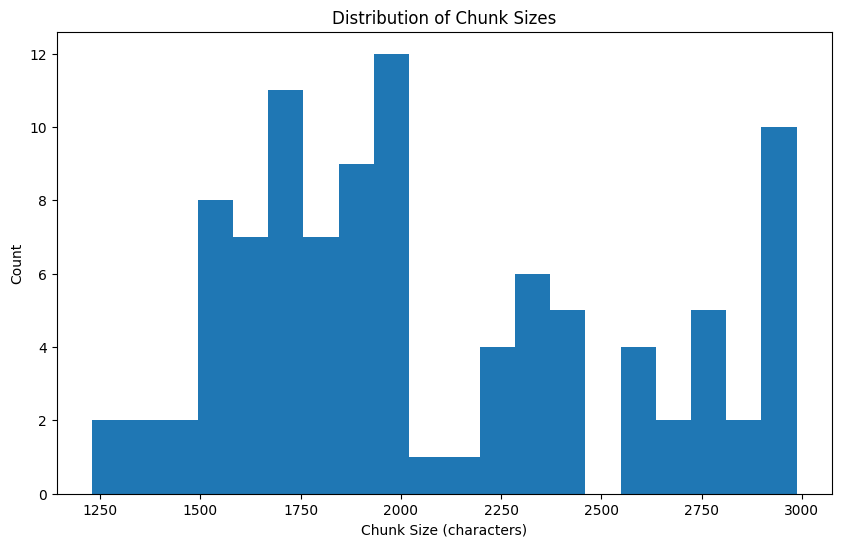


✅ Chunk sizes look good!


In [21]:
# Cell 13: Analyze Current Chunk Sizes
print("🔍 Analyzing current chunk sizes...\n")

# Get a sample of chunks
sample = collection.get(limit=20)

chunk_lengths = [len(doc) for doc in sample['documents']]
print(f"📏 Chunk size statistics:")
print(f"   Min: {min(chunk_lengths)} chars")
print(f"   Max: {max(chunk_lengths)} chars")
print(f"   Average: {sum(chunk_lengths)//len(chunk_lengths)} chars")
print(f"   Total chunks: {collection.count()}")

# Show distribution
print(f"\n📊 Size distribution:")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist([len(doc) for doc in collection.get(limit=100)['documents']], bins=20)
plt.xlabel('Chunk Size (characters)')
plt.ylabel('Count')
plt.title('Distribution of Chunk Sizes')
plt.show()

# Check if chunks are too small
small_chunks = [l for l in chunk_lengths if l < 500]
if len(small_chunks) > len(chunk_lengths) * 0.3:
    print("\n⚠️ WARNING: Many chunks are small! Consider reprocessing with larger chunk_size.")
else:
    print("\n✅ Chunk sizes look good!")

In [22]:
def clear_database():
    """Clear all data from the database"""
    try:
        count_before = collection.count()
        if count_before == 0:
            print("ℹ️  Database is already empty")
            return
            
        response = input(f"⚠️  Delete all {count_before} chunks? Type 'YES' to confirm: ")
        if response == 'YES':
            # Get all IDs
            all_ids = collection.get()['ids']
            if all_ids:
                collection.delete(ids=all_ids)
                print(f"✅ Deleted {count_before} chunks from collection")
            
            # Verify it's empty
            count_after = collection.count()
            print(f"📊 Collection now has {count_after} chunks")
        else:
            print("❌ Operation cancelled")
    except Exception as e:
        print(f"❌ Error clearing database: {e}")

# Test the function
clear_database()

❌ Operation cancelled


In [23]:
collection.peek()  # Or use collection.get() to see chunk IDs


{'ids': ['7_Report - khushi kiran.pdf_chunk_0',
  '7_Report - khushi kiran.pdf_chunk_1',
  '7_Report - khushi kiran.pdf_chunk_2',
  '7_Report - khushi kiran.pdf_chunk_3',
  '7_Report - khushi kiran.pdf_chunk_4',
  '7_Report - khushi kiran.pdf_chunk_5',
  '7_Report - khushi kiran.pdf_chunk_6',
  '7_Report - khushi kiran.pdf_chunk_7',
  '7_Report - khushi kiran.pdf_chunk_8',
  '7_Report - khushi kiran.pdf_chunk_9'],
 'embeddings': array([[ 0.03992383, -0.03474854,  0.00143857, ..., -0.04187942,
         -0.03481762, -0.00952303],
        [ 0.04639997,  0.00105297, -0.03049378, ..., -0.01306829,
          0.00158955, -0.01632661],
        [ 0.03762385, -0.00716431, -0.02531052, ..., -0.03315016,
          0.00358444, -0.02906256],
        ...,
        [ 0.01713736, -0.02314584, -0.01964445, ..., -0.00968083,
          0.02411125, -0.0210966 ],
        [ 0.01552705,  0.01941189, -0.03063391, ..., -0.01251121,
         -0.01839895, -0.02190708],
        [ 0.01649883,  0.02576101, -0.0083029

In [24]:
# Cell 19: Ollama LLM Integration
import ollama

def answer_with_ollama(question, n_chunks=3, model="llama3.1:8b-instruct-q4_0", temperature=0.3):
    """
    Answer questions using local Llama 3.1 with RAG context
    """
    print(f"🤔 Processing question: {question}")
    
    # Get context from RAG
    context = build_context_for_chatbot(question, n_chunks=n_chunks, min_relevance=0.3)
    
    # Check if we found relevant context
    if "couldn't find sufficiently relevant" in context:
        return "I don't have relevant information in the documents to answer this question. Please try rephrasing or ask about topics covered in the uploaded documents."
    
    # Simple prompt
    prompt = f"""Based on the following context from research documents, please answer the question accurately.
If the context doesn't contain enough information, say so.

Context:
{context}

Question: {question}

Answer:"""
    
    try:
        print(f"🚀 Running {model}...")
        response = ollama.chat(
            model=model,
            messages=[
                {'role': 'user', 'content': prompt}
            ],
            options={
                'temperature': temperature,
                'num_predict': 500
            }
        )
        
        return response['message']['content']
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Make sure Ollama is running: 'ollama serve'")
        return f"Error: {str(e)}"

def chat_with_rag():
    """
    Simple interactive chat
    """
    print("🤖 RAG Chatbot with Llama 3.1")
    print("Type 'quit' to exit\n")
    
    # Check Ollama
    try:
        ollama.list()
        print("✅ Ollama is running!\n")
    except:
        print("❌ Start Ollama first: run 'ollama serve' in terminal")
        return
    
    while True:
        question = input("\n❓ Your question: ").strip()
        
        if question.lower() in ['quit', 'exit', 'q']:
            print("👋 Goodbye!")
            break
        
        if not question:
            continue
        
        answer = answer_with_ollama(question)
        print("\n💡 Answer:")
        print(answer)
        print("\n" + "="*50)

# Quick test
def test_qa():
    """Test with a simple question"""
    question = "What methodologies are discussed for plant disease detection?"
    print(f"❓ Test Question: {question}\n")
    
    answer = answer_with_ollama(question)
    print(f"💡 Answer: {answer}")

print("✅ Ollama integration ready!")
print("Usage: test_qa() or chat_with_rag()")

✅ Ollama integration ready!
Usage: test_qa() or chat_with_rag()


In [25]:
# Run this in a new cell to test
answer = answer_with_ollama("What is discussed about plant disease detection?")
print(answer)

🤔 Processing question: What is discussed about plant disease detection?
🔍 Searching for: 'What is discussed about plant disease detection?'
🎯 Reranking 12 candidates...
📋 Found 12 candidates, 10 above threshold, returning top 3:

1. 📄 bs.pdf (ID: chunk_14)
   📖 Chapter 6
   📑 Section 6.1
   📊 Initial: 0.746, Rerank: 5.545, Final: 4.105
   📏 Chunk size: 1723 chars
   📝 Preview: 28 of 46
CHAPTER 6
System Design
6.1 Current System
The systems that exist for plant disease detection mainly follow a two-step process which is to identify
if the plant is healthy or unhealthy using ...

2. 📄 bs.pdf (ID: _chunk_2)
   📖 Chapter 2
   📑 Section 3.1
   📊 Initial: 0.746, Rerank: 5.426, Final: 4.022
   📏 Chunk size: 2603 chars
   📝 Preview: 12 of 46
CHAPTER 2
Problem Definition
The existing manual methods for plant disease detection in agriculture are inefficient and prone to
errors, leading to significant loss of crops and are a huge co...

3. 📄 bs.pdf (ID: chunk_10)
   📖 Chapter 5
   📑 Section 5.1
 

In [26]:
print(f"📦 Total documents in collection: {collection.count()}")


📦 Total documents in collection: 122


In [27]:
import os
print("📁 Exists:", os.path.exists("chromadb_store"))


📁 Exists: True


In [28]:
import inspect

print("📂 Collection name:", collection.name)
print("📦 Total documents:", collection.count())

# Inspect client object to confirm it's a PersistentClient
print("🧪 Client type:", type(chroma_client))

# Optional: Look into where it's storing (if PersistentClient)
print("📍 DB location (guess):", inspect.getsourcefile(type(chroma_client)))


📂 Collection name: rag-chunks
📦 Total documents: 122
🧪 Client type: <class 'chromadb.api.client.Client'>
📍 DB location (guess): C:\Users\jsdha\AppData\Roaming\Python\Python313\site-packages\chromadb\api\client.py


In [29]:
# ✅ Run test QnA
question = "What is the methodology for plant disease detection?"
answer = answer_with_ollama(question)
print("\n💡 Answer:")
print(answer)

🤔 Processing question: What is the methodology for plant disease detection?
🔍 Searching for: 'What is the methodology for plant disease detection?'
🎯 Reranking 12 candidates...
📋 Found 12 candidates, 11 above threshold, returning top 3:

1. 📄 bs.pdf (ID: _chunk_2)
   📖 Chapter 2
   📑 Section 3.1
   📊 Initial: 0.786, Rerank: 7.044, Final: 5.166
   📏 Chunk size: 2603 chars
   📝 Preview: 12 of 46
CHAPTER 2
Problem Definition
The existing manual methods for plant disease detection in agriculture are inefficient and prone to
errors, leading to significant loss of crops and are a huge co...

2. 📄 bs.pdf (ID: chunk_14)
   📖 Chapter 6
   📑 Section 6.1
   📊 Initial: 0.766, Rerank: 6.551, Final: 4.815
   📏 Chunk size: 1723 chars
   📝 Preview: 28 of 46
CHAPTER 6
System Design
6.1 Current System
The systems that exist for plant disease detection mainly follow a two-step process which is to identify
if the plant is healthy or unhealthy using ...

3. 📄 bs.pdf (ID: chunk_10)
   📖 Chapter 5
   📑 Secti